In [1]:
from LOD import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy import sparse
import scipy.linalg as la
import scipy.sparse.linalg as spla
from scipy.spatial.distance import cdist
from scipy.special import kv, gamma
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import LinearNDInterpolator

In [2]:
# mesh parameters
H = 2**(-3)
h = 2**(-7)

Nx = int(1 / H)
Ny = Nx
refine = int(H / h)

mesh = build_triangular_mesh(Nx, Ny, refine)

coarse_nodes = mesh["coarse_nodes"]
fine_nodes   = mesh["fine_nodes"]
coarse_elems = mesh["coarse_elems"]
fine_elems   = mesh["fine_elems"]

N_H = coarse_nodes.shape[0]
N_h = fine_nodes.shape[0]

In [3]:
class SEGaussianSamplerSVD:
    def __init__(self, pos, sigma=1.0, ell=0.3, mean=1.0, tol=1e-8):
        self.pos = np.asarray(pos, dtype=float)
        self.V = self.pos.shape[0]

        # Pairwise distances
        D = cdist(self.pos, self.pos)

        # Covariance matrix for GRF
        C = (sigma**2) * np.exp(-(D**2) / (2 * ell**2))

        U, s, _ = np.linalg.svd(C, full_matrices=False)

        if np.min(s) < -tol:
            raise ValueError(f"Covariance not PSD: min eigen/singular {np.min(s)} < -tol")
        s = np.clip(s, 0.0, None)

        self.A = U * np.sqrt(s)[None, :]
        self.mean = mean

    def sample(self, rng: np.random.Generator):
        z = rng.normal(0.0, 1.0, size=(self.V,))
        return self.mean + self.A @ z

In [4]:
def compute_kappa_per_element(coarse_elems, kappa_node):
    """
    Compute elementwise-constant kappa on coarse mesh.

    Returns
    -------
    kappa_elem : (N_elem,) ndarray
    """
    kappa_elem = np.zeros(len(coarse_elems))
    for l, elem in enumerate(coarse_elems):
        kappa_elem[l] = np.mean(kappa_node[list(elem)])
    return kappa_elem

def make_fast_kappa_uniform(h, Nx, kappa_elem):
    def kappa(x, y):
        i = min(int(x // h), Nx - 1)
        j = min(int(y // h), Nx - 1)

        # quad index
        q = j * Nx + i

        # two triangles per quad
        # consistent with quads_to_tris(bl-tr)
        if (x - i*h) + (y - j*h) <= h:
            l = 2*q       # lower-left triangle
        else:
            l = 2*q + 1   # upper-right triangle

        return kappa_elem[l]

    return kappa

In [ ]:
sigma = 1.0
ell = 0.3
sampler = SEGaussianSamplerSVD(fine_nodes, sigma=sigma, ell=ell, mean=1.0, tol=1e-8)

In [ ]:
epsi = 0.01
kappa_values = np.array([epsi, 4.0, 8.0, 12.0, 16.0, 20.0])

rng = np.random.default_rng()
a_sample = sampler.sample(rng)
a_sample = np.exp(a_sample)
q_edges = np.quantile(a_sample, np.linspace(0, 1, kappa_values.shape[0]+1))
            
kappa_shuffled = np.asarray(kappa_values, dtype=float).copy()
rng.shuffle(kappa_shuffled)
            
bins = np.searchsorted(q_edges[1:], a_sample, side="right")
bins = np.clip(bins, 0, len(kappa_values)-1)
kappa_node = kappa_shuffled[bins]
            
kappa_elem = compute_kappa_per_element(fine_elems, kappa_node)
kappa = make_fast_kappa_uniform(h, int(1 / h), kappa_elem)

N = 128
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(x, y, indexing="ij")

# vectorize scalar kappa
kappa_vec = np.vectorize(kappa)

K = kappa_vec(X, Y)

plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, K, shading="auto", cmap="viridis")
plt.colorbar(label=r"$\kappa(x,y)$")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [138]:
rough_coeff = lambda x,y: kappa(x,y)

print("Assemble Stiffness Matrix...")
A_dc, M_dc, sigma = build_fine_element_matrices(mesh, rough_coeff, n_jobs=-1)

print("Assemble global...")
A_h, M_h = assemble_global_from_Adc_Mdc(A_dc, M_dc, sigma, N_h)

print("Assemble load vec...")
# load vector f ≡ 1
f_h = assemble_load_tri(
    fine_nodes, fine_elems, lambda x, y: 1.0
)

# interpolation and boundary matrices
print("Assemble interpolation matrix...")
P_h = build_P_triangular(mesh)
print("Assemble B_H")
B_H = build_B_H(coarse_nodes, Nx, Ny)

Assemble Stiffness Matrix...
Assemble global...
Assemble load vec...
Assemble interpolation matrix...
Assemble B_H


In [139]:
adjacency = build_coarse_adjacency_edge(coarse_elems)
fine_in_coarse = precompute_fine_in_coarse(mesh)

In [140]:
C_h = build_IH_quasi_interpolation(mesh)

In [ ]:
k=4
Q_h = computeCorrections(mesh, k, adjacency, fine_in_coarse, A_h, B_H, C_h, rough_coeff, n_jobs=-1)

In [142]:
u_h_LOD, u_H_LOD = solveLODSystem(
    A_h, f_h, P_h, Q_h, B_H
)

In [143]:
u_h_fine = solve_fine_problem(A_h, f_h, fine_nodes)

In [145]:
np.linalg.norm(u_h_LOD - u_h_fine) / np.linalg.norm(u_h_fine)

np.float64(0.019848099441266608)

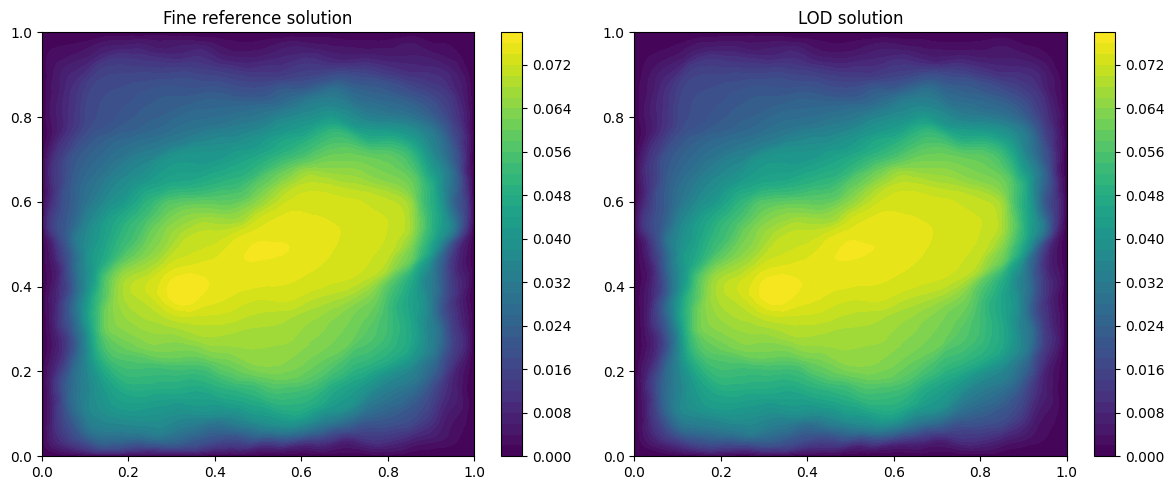

In [146]:
tri = mtri.Triangulation(
    fine_nodes[:,0],
    fine_nodes[:,1],
    fine_elems
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.tricontourf(tri, u_h_fine, levels=50)
plt.colorbar()
plt.title("Fine reference solution")

plt.subplot(1,2,2)
plt.tricontourf(tri, u_h_LOD, levels=50)
plt.colorbar()
plt.title("LOD solution")

plt.tight_layout()
plt.show()